In [118]:
from pathlib import Path
import time
import torch
import numpy as np
import pandas as pd
from dataset import LinearDynamicalDataset, WHDataset, CSTRDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
#import plotly.graph_objects as go
from transformer_onestep import GPTConfig, GPT
import tqdm
import argparse
import metrics

In [119]:
fig_path = Path("fig")
fig_path.mkdir(exist_ok=True)

In [120]:
# Fix all random sources to make script fully reproducible
torch.manual_seed(420)
np.random.seed(430)
system_seed = 430 # Controls the system generation
data_seed = 0 # Control the input generation

In [121]:
# Overall settings
out_dir = "out"

# System settings
nu = 3
ny = 2
#seq_len = 600
batch_size = 100 # 256


# Compute settings
cuda_device = "cuda:1"
no_cuda = True
threads = 5
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
#torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
#torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn

In [122]:
# Create out dir
out_dir = Path(out_dir)
#exp_data = torch.load(out_dir/"ckpt_onestep_wh_medium.pt", map_location=device)
#exp_data = torch.load(out_dir/"ckpt_onestep_wh_large.pt", map_location=device)
exp_data = torch.load(out_dir/"ckpt_onestep_cstr_filter_no_normed_no_skip_ny2_prbs.pt", map_location=device)

In [123]:
exp_data.keys()
# np.sqrt(exp_data['best_val_loss'])
# print(len(exp_data['LOSS']))
# print(len(exp_data['LOSS_VAL']))

dict_keys(['model', 'optimizer', 'model_args', 'iter_num', 'train_time', 'LOSS', 'LOSS_VAL', 'best_val_loss', 'cfg'])

In [124]:
exp_data['model_args']

{'n_layer': 12,
 'n_head': 4,
 'n_embd': 128,
 'n_y': 2,
 'n_u': 3,
 'block_size': 700,
 'bias': False,
 'dropout': 0.0}

In [125]:
seq_len = exp_data["cfg"].seq_len
nx = exp_data["cfg"].nx

In [126]:
model_args = exp_data["model_args"]
gptconf = GPTConfig(**model_args)
model = GPT(gptconf).to(device)


state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict);

number of parameters: 2.45M


In [127]:
# Create data loader
load_test_ds = False

# if load_test_ds:
#     test_dl = torch.load('dataloader_cstr_np_normed_no_skip.pt')
# else:
#     test_ds = CSTRDataset(nx=nx, nu=nu, ny=ny, seq_len=seq_len, system_seed=system_seed, data_seed=data_seed, fixed_system=False)
#     test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=threads)
#     torch.save(test_dl, 'dataloader_cstr_filter_no_normed_no_skip.pt')

In [128]:
import pickle as pkl
with open('data/test_set_prbs_lungo.pkl', 'rb') as f:
    test_set = pkl.load(f)
u_test = test_set['u_test']
x_n_test = test_set['x_n_test']
x_test = test_set['x_test']
y_test = test_set['y_test']
data_test = test_set['data_test']

batch_u = torch.Tensor(np.concatenate((u_test, np.expand_dims(y_test[:,:,1], axis=2)), axis=2))
#batch_y = torch.Tensor(np.expand_dims(x_n_test[:,:,0], axis=2))#x_n_test)
batch_y = torch.Tensor(x_n_test)

In [129]:
batch_y[0:1,0:50].shape

torch.Size([1, 50, 2])

In [130]:
import time
#batch_y, batch_u = next(iter(test_dl))
batch_y = batch_y.to(device)
batch_u = batch_u.to(device)
batch_y_pred= torch.Tensor(batch_y.shape)

ell = 500

time_vec = []
with torch.no_grad():
    for i in range(2):#batch_u.shape[0]): # for each system
        print(i)

        pred, _ = model(batch_u[i:i+1,:500,:], batch_y[i:i+1, :500,:])
        batch_y_pred[i, :500, :] = pred
        
        pred, _ = model(batch_u[i:i+1, -500:,:], batch_y[i:i+1, -500:, :])
        batch_y_pred[i, -500:, :] = pred
        
    batch_y_pred = batch_y_pred.to("cpu").detach().numpy()
    batch_y = batch_y.to("cpu").detach().numpy()
    batch_u = batch_u.to("cpu").detach().numpy()
#elapsed_time = time.time() - start
#print(elapsed_time)

0
1


In [114]:
import time
#batch_y, batch_u = next(iter(test_dl))
batch_y = batch_y.to(device)
batch_u = batch_u.to(device)
batch_y_pred= torch.Tensor(batch_y.shape)

ell = 500

time_vec = []
with torch.no_grad():
    for i in range(2):#batch_u.shape[0]): # for each system
        print(i)
        for t in range(0, batch_u.shape[1]):
            #print(t)
            start = time.time()
            
            if t < ell:
                pred, _ = model(batch_u[i:i+1,:t+1,:], batch_y[i:i+1, :t+1,:])
            else:
                pred, _ = model(batch_u[i:i+1,t-ell+1:t+1,:], batch_y[i:i+1,t-ell+1:t+1,:])
            print('time:',t)
            print('shape:',pred.shape)
            time_vec.append(time.time() - start)
            
            batch_y_pred[i, t, :] = pred[:, -1, :]
            #print(pred.shape)
            #break
        #break
        #batch_y_pred[i] = pred # last sample
        #start = time.time()
        #batch_y_pred[i], _ = model(batch_u[i:i+1], batch_y[i:i+1])
        #time_vec.append(time.time() - start)
    batch_y_pred = batch_y_pred.to("cpu").detach().numpy()
    batch_y = batch_y.to("cpu").detach().numpy()
    batch_u = batch_u.to("cpu").detach().numpy()
#elapsed_time = time.time() - start
#print(elapsed_time)

0
time: 0
shape: torch.Size([1, 1, 2])
time: 1
shape: torch.Size([1, 2, 2])
time: 2
shape: torch.Size([1, 3, 2])
time: 3
shape: torch.Size([1, 4, 2])
time: 4
shape: torch.Size([1, 5, 2])
time: 5
shape: torch.Size([1, 6, 2])
time: 6
shape: torch.Size([1, 7, 2])
time: 7
shape: torch.Size([1, 8, 2])
time: 8
shape: torch.Size([1, 9, 2])
time: 9
shape: torch.Size([1, 10, 2])
time: 10
shape: torch.Size([1, 11, 2])
time: 11
shape: torch.Size([1, 12, 2])
time: 12
shape: torch.Size([1, 13, 2])
time: 13
shape: torch.Size([1, 14, 2])
time: 14
shape: torch.Size([1, 15, 2])
time: 15
shape: torch.Size([1, 16, 2])
time: 16
shape: torch.Size([1, 17, 2])
time: 17
shape: torch.Size([1, 18, 2])
time: 18
shape: torch.Size([1, 19, 2])
time: 19
shape: torch.Size([1, 20, 2])
time: 20
shape: torch.Size([1, 21, 2])
time: 21
shape: torch.Size([1, 22, 2])
time: 22
shape: torch.Size([1, 23, 2])
time: 23
shape: torch.Size([1, 24, 2])
time: 24
shape: torch.Size([1, 25, 2])
time: 25
shape: torch.Size([1, 26, 2])
tim

In [286]:
batch_y_pred.shape

(100, 500, 2)

In [287]:
time_vec

[0.005505084991455078,
 0.006011009216308594,
 0.0065190792083740234,
 0.0075054168701171875,
 0.006012678146362305,
 0.0055463314056396484,
 0.005964517593383789,
 0.005517005920410156,
 0.005505561828613281,
 0.00652766227722168,
 0.0065174102783203125,
 0.0060002803802490234,
 0.006513833999633789,
 0.006508588790893555,
 0.006003379821777344,
 0.00651240348815918,
 0.008526802062988281,
 0.005997180938720703,
 0.007516384124755859,
 0.006516695022583008,
 0.007506608963012695,
 0.008009672164916992,
 0.008534908294677734,
 0.009033679962158203,
 0.0075147151947021484,
 0.007517576217651367,
 0.007997512817382812,
 0.007520914077758789,
 0.007534503936767578,
 0.006506681442260742,
 0.007005453109741211,
 0.008517742156982422,
 0.009186506271362305,
 0.010533809661865234,
 0.010504484176635742,
 0.007515430450439453,
 0.013525962829589844,
 0.010535240173339844,
 0.013575077056884766,
 0.010521650314331055,
 0.009508609771728516,
 0.009519577026367188,
 0.010518074035644531,
 0.0105

In [288]:
np.std(time_vec)/500 * 1000

0.0034243065093202602

In [289]:
# batch_y_target = batch_y[:, 1:, :] # target @ time k: y_{k+1}
# batch_y_pred = batch_y_pred[:, :-1, :] # prediction @ time k: y_{k+1|k} / filter @ time k: y_{k|k}
# batch_y_pred_dummy = batch_y[:, :-1, :] # dummy estimator: y_{k+1} \approx y_{k}
# batch_pred_err = batch_y_target - batch_y_pred
# batch_pred_err_dummy = batch_y_target - batch_y_pred_dummy
batch_pred_err = batch_y - batch_y_pred
# batch_pred_err_dummy = batch_y_target - batch_y_pred_dummy

In [290]:
t = np.arange(1, batch_y.shape[1]+1)

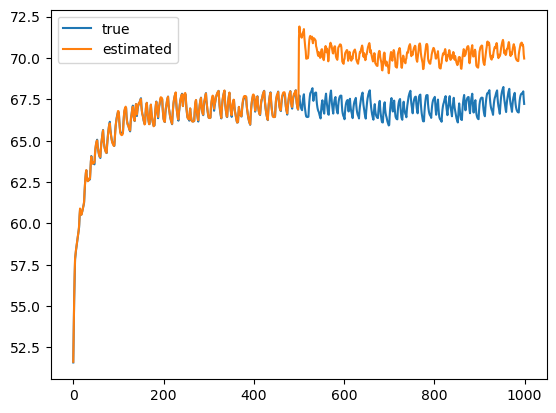

In [131]:
test_idx = 0
plt.plot(batch_y[test_idx,:,1], label='true')
plt.plot(batch_y_pred[test_idx,:,1], label='estimated')
#plt.xlim([200, 300])
plt.legend()
plt.show()

In [298]:
transformer_data = {'t': t,
            'u1': u_test[:, :, 0],
            'u2': u_test[:, :, 1],
            'x1_n': x_n_test[:, :, 0],
            'x2_n': x_n_test[:, :, 1],
            'x1': x_test[:, :, 0],
            'x2': x_test[:, :, 1],
            'y1': y_test[:, :, 0],
            'y2': y_test[:, :, 1],
            'x1_hat': batch_y_pred[:, :, 0],
            'x2_hat': batch_y_pred[:, :, 1],
            'time': np.reshape(time_vec, (u_test.shape[0], -1))
            }

with open("data/transformer_prbs_data2.pkl", "wb") as f:
    pkl.dump(transformer_data, f)

In [155]:
batch_y_pred[0, -1, :]

array([76.35701 , 57.814346], dtype=float32)

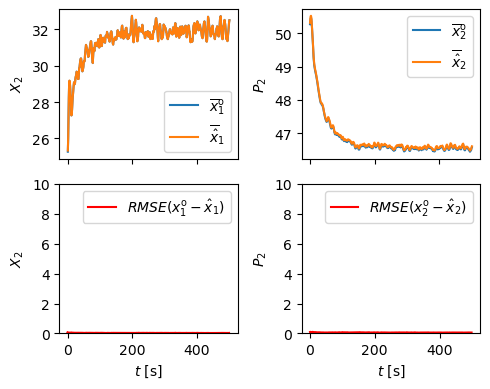

In [244]:
x1_n_mean = batch_y[:,:,0].mean(axis=0)
# x1_mean = x_test[:,:,0].mean(axis=0)
x1_hat_mean = batch_y_pred[:,:,0].mean(axis=0)
x1_err_mean = np.sqrt(np.power(batch_y[:,:,0] - batch_y_pred[:,:,0], 2).mean(axis=0))
x2_n_mean = batch_y[:,:,1].mean(axis=0)
# x2_mean = x_test[:,:,1].mean(axis=0)
x2_hat_mean = batch_y_pred[:,:,1].mean(axis=0)
x2_err_mean = np.sqrt(np.power(batch_y[:,:,1] - batch_y_pred[:,:,1], 2).mean(axis=0))
# y2_mean = y_test[:,:,1].mean(axis=0)

fig = plt.figure(figsize=(5,4))

ax1 = plt.subplot(221)
# plt.plot(t, x1_mean, label='$\overline{x}_1$')
plt.plot(t, x1_n_mean, label='$\overline{x}^{\mathrm{o}}_1$')
plt.plot(t, x1_hat_mean, label='$\overline{\hat{x}}_1$')
plt.tick_params('x', labelbottom=False)
plt.ylabel('$X_2$')
plt.legend(loc="lower right")

ax2 = plt.subplot(223, sharex=ax1)
plt.plot(x1_err_mean, c='r', label='$RMSE(x^{\mathrm{o}}_1 - \hat{x}_1)$')
plt.xlabel('$t$ [s]')
plt.ylabel('$X_2$')
plt.ylim([0, 10])
plt.legend()

ax3 = plt.subplot(222)
# plt.plot(t, y2_mean, label='$\overline{y}$')
# plt.plot(t, x2_mean, label='$\overline{x}_2$')
plt.plot(t, x2_n_mean, label='$\overline{x}^{\mathrm{o}}_2$')
plt.plot(t, x2_hat_mean, label='$\overline{\hat{x}}_2$')
plt.tick_params('x', labelbottom=False)
plt.ylabel('$P_2$')
plt.legend(loc="upper right")

ax4 = plt.subplot(224, sharex=ax1)
plt.plot(x2_err_mean, c='r', label='$RMSE(x^{\mathrm{o}}_2 - \hat{x}_2)$')
plt.xlabel('$t$ [s]')
plt.ylabel('$P_2$')
plt.ylim([0, 10])
plt.legend()

plt.tight_layout()
#plt.savefig('transformer_2.pdf')
plt.show()

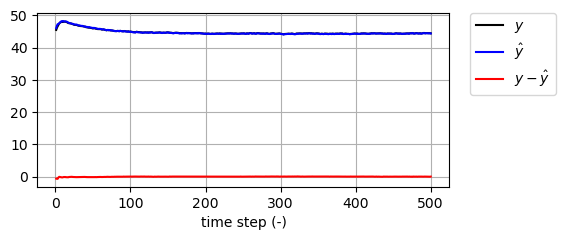

In [16]:
plt.figure(figsize=(10, 2.5))

idx = 31
plt.subplot(121)
plt.plot(t, batch_y[idx,:,1], 'k', label="$y$")
plt.plot(t, batch_y_pred[idx,:,1], 'b', label="$\hat y$")
#plt.plot(batch_y_pred_dummy[idx], 'm', label="Pred dummy")
plt.plot(t, batch_y[idx,:,1] - batch_y_pred[idx,:,1], 'r', label="$y - \hat y$")
#plt.plot(batch_y_target[idx] - batch_y_pred_dummy[idx], 'm', label="Err dummy")
#plt.legend(loc="upper right")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()
#plt.xlim([0, 100]);
#plt.ylim([-3, 3]);
plt.xlabel("time step (-)")

# plt.subplot(122)
# plt.plot(t, batch_y_target[idx,:,1], 'k', label="$y$")
# plt.plot(t, batch_y_pred[idx,:,1], 'b', label="$\hat y$")
# #plt.plot(batch_y_pred_dummy[idx], 'm', label="Pred dummy")
# plt.plot(t, batch_y_target[idx,:,1] - batch_y_pred[idx,:,1], 'r', label="$y - \hat y$")
# #plt.plot(batch_y_target[idx] - batch_y_pred_dummy[idx], 'm', label="Err dummy")
# #plt.legend(loc="upper right")
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.grid()
# #plt.xlim([0, 100]);
# #plt.ylim([-3, 3]);
# plt.xlabel("time step (-)")

plt.tight_layout()
#plt.savefig(fig_path / "cstr_one_step_single.pdf")

In [17]:
batch_y

array([[[ 29.486588,  58.67005 ],
        [ 39.43094 ,  60.400284],
        [ 49.965137,  61.72488 ],
        ...,
        [117.29676 ,  53.305386],
        [115.626945,  53.225586],
        [117.17618 ,  53.316315]],

       [[ 21.344948,  42.47047 ],
        [ 25.406036,  44.017647],
        [ 28.608168,  45.28218 ],
        ...,
        [ 20.96779 ,  64.370766],
        [ 20.809206,  64.3256  ],
        [ 20.866812,  64.3459  ]],

       [[ 26.31507 ,  52.35962 ],
        [ 27.462614,  52.441795],
        [ 28.809301,  52.55713 ],
        ...,
        [ 33.702606,  52.98379 ],
        [ 34.327915,  53.04898 ],
        [ 34.564445,  53.08702 ]],

       ...,

       [[ 22.395462,  44.5607  ],
        [ 20.347868,  44.167877],
        [ 18.758541,  43.790226],
        ...,
        [ 17.547491,  39.723915],
        [ 17.955297,  39.83626 ],
        [ 17.987352,  39.860382]],

       [[ 23.7943  ,  47.343994],
        [ 19.547478,  47.38001 ],
        [ 17.183064,  47.479187],
        .

In [18]:
x1_mean = y[:,:,0].mean(axis=0)
x1_hat_mean = y_hat[:,:, 0].mean(axis=0)
x1_err_mean = np.sqrt(np.power(y[:,:,0] - y_hat[:,:,0], 2).mean(axis=0))
x2_mean = y[:,:,1].mean(axis=0)
x2_hat_mean = y_hat[:,:,1].mean(axis=0)
x2_err_mean = np.sqrt(np.power(y[:,:,1] - y_hat[:,:,1], 2).mean(axis=0))

fig = plt.figure(figsize=(5,3))

ax1 = plt.subplot(221)
plt.plot(t, x1_mean, label='$\overline{x}_1$')
plt.plot(t, x1_hat_mean, label='$\overline{\hat{x}}_1$')
plt.tick_params('x', labelbottom=False)
plt.ylabel('$X_2$')
plt.legend(loc="lower right")

ax2 = plt.subplot(223, sharex=ax1)
plt.plot(x1_err_mean, c='r', label='$RMSE(x_1 - \hat{x}_1)$')
plt.xlabel('$t$ [s]')
plt.ylabel('$X_2$')
plt.legend()

ax3 = plt.subplot(222)
plt.plot(t, x2_mean, label='$\overline{y} = \overline{x}_2$')
plt.plot(t, x2_hat_mean, label='$\overline{\hat{x}}_2$')
plt.tick_params('x', labelbottom=False)
plt.ylabel('$P_2$')
plt.legend(loc="upper right")

ax4 = plt.subplot(224, sharex=ax1)
plt.plot(x2_err_mean, c='r', label='$RMSE(x_2 - \hat{x}_2)$')
plt.xlabel('$t$ [s]')
plt.ylabel('$P_2$')
plt.legend()

plt.tight_layout()
#plt.savefig('ekf_2.pdf')
plt.show()

NameError: name 'y' is not defined

In [ ]:
plt.figure(figsize=(9, 6))
#plt.title("Prediction error $y - \hat y$ on 256 sequences")
plt.subplot(211)
plt.plot(t, batch_y[:,:,0].squeeze().T, "k", alpha=0.5);
plt.plot(t, batch_y_pred[:,:,0].squeeze().T, "b", alpha=0.5);
plt.plot(t, np.nan*np.zeros(t.shape), "k", alpha=1.0, label="$y$")
plt.plot(t, np.nan*np.zeros(t.shape), "b", alpha=1.0, label="$\hat y$")
#plt.plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y - \hat y$")
plt.grid(True)
plt.margins(x=0)
#plt.legend(loc="upper right")
plt.legend()
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("time step (-)")

plt.subplot(212)
plt.plot(t, batch_pred_err[:,:,0].squeeze().T, "r", alpha=0.2)
plt.plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y - \hat y$")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("time step (-)")
# plt.plot(t, batch_y_target[:,:,1].squeeze().T, "k", alpha=0.5);
# plt.plot(t, np.nan*np.zeros(t.shape), "k", alpha=1.0, label="$y$")
# plt.plot(t, batch_pred_err[:,:,1].squeeze().T, "r", alpha=0.2);
# plt.plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y - \hat y$");
plt.grid(True)
plt.margins(x=0)
plt.legend(loc="upper right")
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.xlabel("time step (-)")

plt.tight_layout()
#plt.xlabel("Time step $k$");
plt.savefig(fig_path / "cstr_one_step_batch.pdf")

In [ ]:
skip = 200
rmse_transformer = metrics.rmse(batch_y_target[:, skip:, :], batch_y_pred[:, skip:, :], time_axis=1)
rmse_dummy = metrics.rmse(batch_y_target[:, skip:, :], batch_y_pred_dummy[:, skip:, :], time_axis=1)

In [ ]:
print(f'iterations: {exp_data["cfg"].max_iters}')
print(f'train_time: {exp_data["train_time"] / 3600 / 24} days')
print(f'rmse: {rmse_transformer.mean()}')